In [2]:
# Basic libraries
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import os
from PIL import Image
# Image processing libraries
import cv2
# Utility libraries
from sklearn.model_selection import train_test_split
from IPython.display import Image, display
# TensorFlow and Keras libraries
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import (Input, Activation, BatchNormalization,
                                     Dropout, Lambda, Conv2D,
                                     Conv2DTranspose, MaxPooling2D,
                                     concatenate)
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [2]:
data = "/kaggle/input/lgg-mri-segmentation/kaggle_3m"

images = []

masks = []

for filenames in os.walk(data):

    for filename in filenames[2]:

        if 'mask'in filename:

            masks.append(f'{filenames[0]}/{filename}')

            images.append(f'{filenames[0]}/{filename.replace("_mask", "")}')

In [3]:
df = pd.DataFrame({'image': images, 'mask': masks})

df.head()

image  \
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...   

                                                mask  
0  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
1  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
2  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
3  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...  
4  /kaggle/input/lgg-mri-segmentation/kaggle_3m/T...

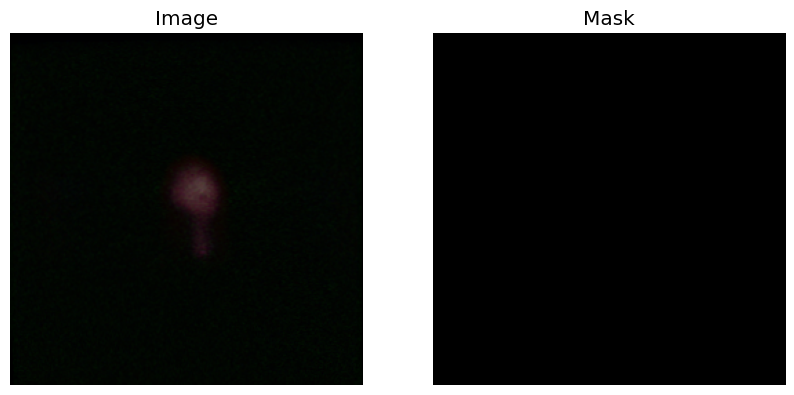

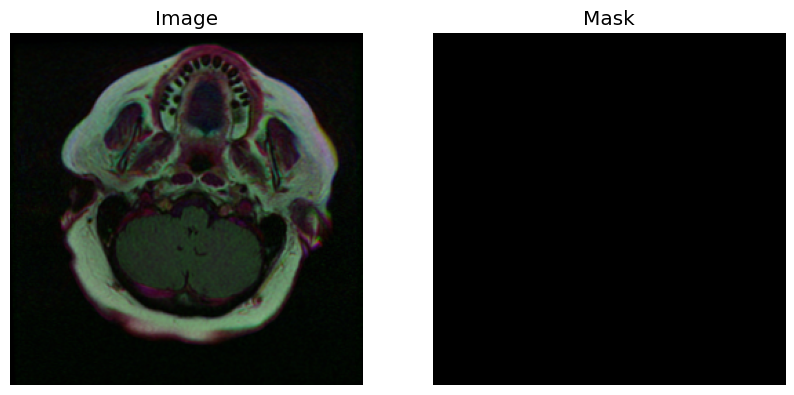

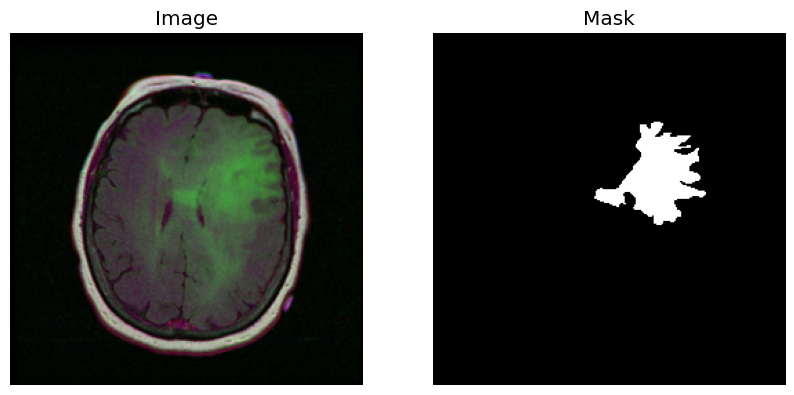

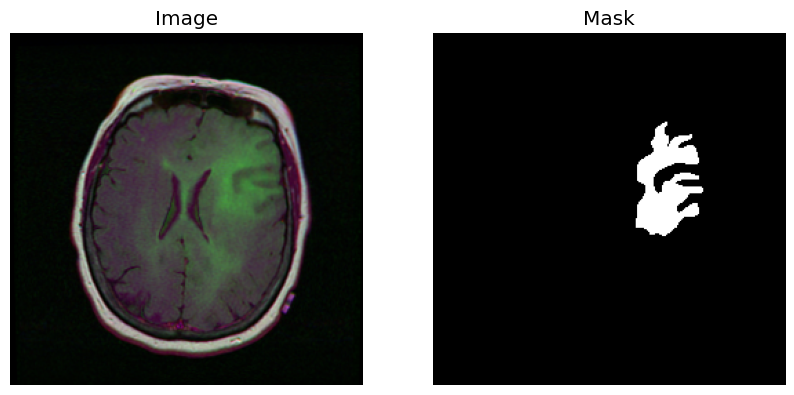

In [4]:
count = 0

for image,mask in zip(df['image'],df['mask']):

    if count==4:
        break

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1,2,1)
    plt.title('Image')
    plt.imshow(cv2.imread(image))
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title('Mask')
    plt.imshow(cv2.imread(mask))
    plt.axis('off')
    
    plt.show()
    count+=1

In [5]:
def plot_image(rows, columns, list_img_path, list_mask_path):

  fig = plt.figure(figsize  = (12,12))

  for i in range(1, rows*columns+1):

    fig.add_subplot(rows, columns, i)
    img = cv2.imread(list_img_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(list_mask_path[i])
    plt.imshow(img)
    plt.imshow(mask, alpha=0.5)
    plt.axis('off')

  plt.show()

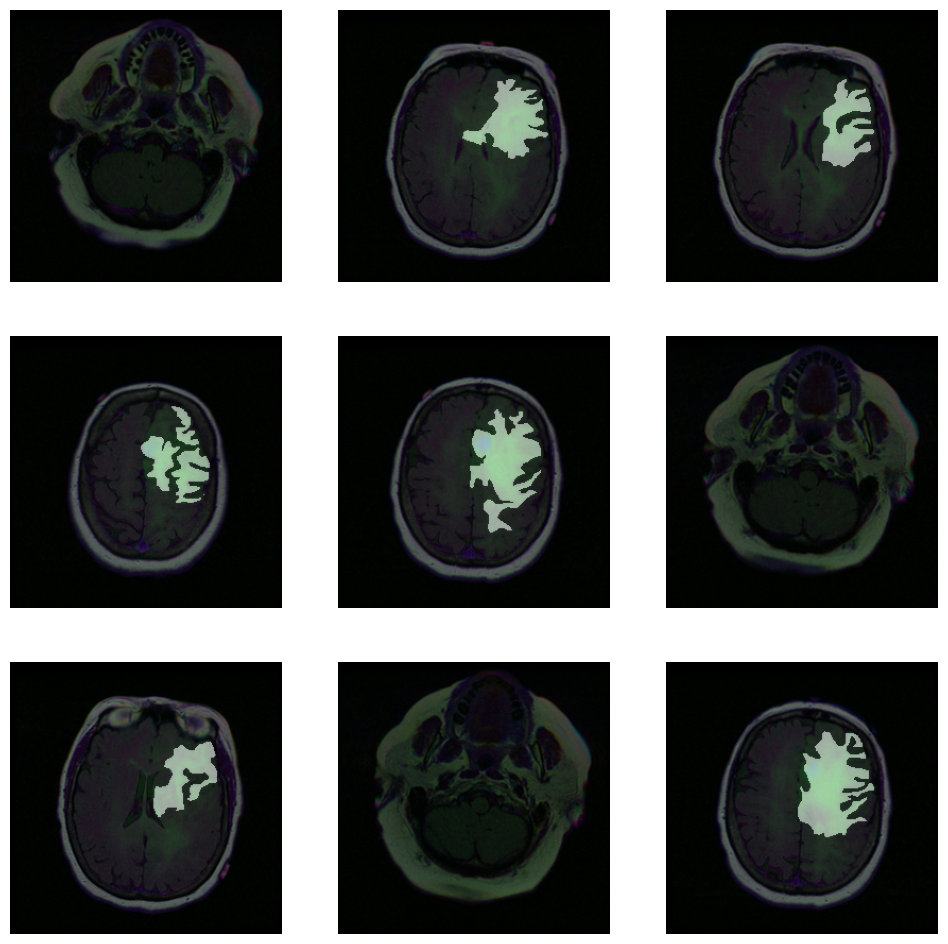

In [6]:
plot_image(3,3,df['image'],df['mask'])

In [7]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=0)

In [8]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(3182, 2)
(354, 2)
(393, 2)


In [9]:
img_size = (128, 128)
batch_size = 40
epochs = 100

In [10]:
def create_gens(df, aug_dict):

    img_gen = ImageDataGenerator(**aug_dict)
    msk_gen = ImageDataGenerator(**aug_dict)

    # Create general generator

    image_gen = img_gen.flow_from_dataframe(df, x_col='image', class_mode=None, color_mode='rgb', target_size=img_size,

                                            batch_size=batch_size, save_to_dir=None, save_prefix='image', seed=1)

    mask_gen = msk_gen.flow_from_dataframe(df, x_col='mask', class_mode=None, color_mode='grayscale', target_size=img_size,

                                            batch_size=batch_size, save_to_dir=None, save_prefix= 'mask', seed=1)

    
    gen = zip(image_gen, mask_gen)

    for (img, msk) in gen:

        img = img / 255
        msk = msk / 255
        
        msk[msk > 0.5] = 1
        msk[msk <= 0.5] = 0
        
        yield (img, msk)

In [11]:
tr_aug_dict = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [12]:
train_gen = create_gens(df_train, aug_dict=tr_aug_dict)
valid_gen = create_gens(df_val, aug_dict={})
test_gen = create_gens(df_test, aug_dict={})

In [13]:
# function to create dice coefficient

def dice_coef(y_true, y_pred, smooth=100):

    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)


# function to create dice loss

def dice_loss(y_true, y_pred, smooth=100):
    return -dice_coef(y_true, y_pred, smooth)

# function to create iou coefficient

def iou_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

# ***Build Model***

In [14]:
def conv_block(input, num_filters):

    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(input)

    conv = BatchNormalization()(conv)

    conv = Conv2D(num_filters, (3, 3), activation="relu", padding="same", kernel_initializer='he_normal')(conv)

    conv = BatchNormalization()(conv)

    return conv

In [15]:
def encoder_block(input, num_filters):

    conv = conv_block(input, num_filters)
    pool = MaxPooling2D((2, 2))(conv)
    return conv, pool

In [16]:
def decoder_block(input, skip_features, num_filters):

    uconv = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    con = concatenate([uconv, skip_features])
    conv = conv_block(con, num_filters)

    return conv

In [17]:
def build_model(input_shape):

    input_layer = Input(input_shape)

    # Encoder path
    s1, p1 = encoder_block(input_layer, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)
    
    # Decoder path
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output layer
    output_layer = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  # For binary segmentation

    # Build and compile the model
    model = Model(inputs=input_layer, outputs=output_layer, name="U-Net")

    return model

In [18]:
# Define input shape
input_shape = (128,128, 3)

# Build and compile the model

model = build_model(input_shape=input_shape)

model.compile(optimizer=Adam(learning_rate=0.001), loss=dice_loss, metrics=['accuracy', iou_coef, dice_coef])

In [19]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [20]:
#ealystopping=tf.keras.callbacks.EarlyStopping(patience=15,
                                          #  monitor='val_accuracy',
                                            #restore_best_weights=True)

#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 #factor=0.2,
                                                # patience=10,
                                                # min_lr=1e-7,
                                                # mode='min')

In [21]:
# Set training parameters
history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) // batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = valid_gen,
                    validation_steps=len(df_val) // batch_size)

Found 3182 validated image filenames.
Found 3182 validated image filenames.
Epoch 1/100


I0000 00:00:1730972875.227494     660 service.cc:145] XLA service 0x7ed170002b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730972875.227554     660 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730972902.212014     660 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7929 - dice_coef: 0.0881 - iou_coef: 0.0472 - loss: -0.0881Found 354 validated image filenames.
Found 354 validated image filenames.
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 351ms/step - accuracy: 0.7939 - dice_coef: 0.0886 - iou_coef: 0.0475 - loss: -0.0886 - val_accuracy: 0.0113 - val_dice_coef: 0.0209 - val_iou_coef: 0.0107 - val_loss: -0.0209
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 52s 430ms/step - accuracy: 0.9514 - dice_coef: 0.2389 - iou_coef: 0.1406 - loss: -0.2396 - val_accuracy: 0.1366 - val_dice_coef: 0.0107 - val_iou_coef: 0.0055 - val_loss: -0.0108
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 308ms/step - accuracy: 0.9870 - dice_coef: 0.4451 - iou_coef: 0.3005 - loss: -0.4531 - val_accuracy: 0.6860 - val_dice_coef: 5.3895e-04 - val_iou_coef: 5.2021e-04 - val_loss: -5.3755e-04
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 26s 324ms/step - accuracy: 0.9907 - dice_coef: 0.5421 - iou_coef: 0.3880 - loss: -0.5443 - val_accuracy: 0.9889 - val_d

In [22]:
ts_length = len(df_test)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)


print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("Train IoU: ", train_score[2])
print("Train Dice: ", train_score[3])
print('-' * 20)

print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print("Valid IoU: ", valid_score[2])
print("Valid Dice: ", valid_score[3])
print('-' * 20)

print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])
print("Test IoU: ", test_score[2])
print("Test Dice: ", test_score[3])

131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 307ms/step - accuracy: 0.9974 - dice_coef: 0.8553 - iou_coef: 0.7516 - loss: -0.8551
131/131 ━━━━━━━━━━━━━━━━━━━━ 17s 128ms/step - accuracy: 0.9973 - dice_coef: 0.8514 - iou_coef: 0.7449 - loss: -0.8512
Found 393 validated image filenames.
Found 393 validated image filenames.
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 190ms/step - accuracy: 0.9975 - dice_coef: 0.8686 - iou_coef: 0.7717 - loss: -0.8687
Train Loss:  -0.8545165657997131
Train Accuracy:  0.9973224997520447
Train IoU:  0.7506957054138184
Train Dice:  0.8546218872070312
--------------------
Valid Loss:  -0.8518339395523071
Valid Accuracy:  0.9972642660140991
Valid IoU:  0.7457581162452698
Valid Dice:  0.8519228100776672
--------------------
Test Loss:  -0.8695995807647705
Test Accuracy:  0.9974812865257263
Test IoU:  0.7725857496261597
Test Dice:  0.869462788105011


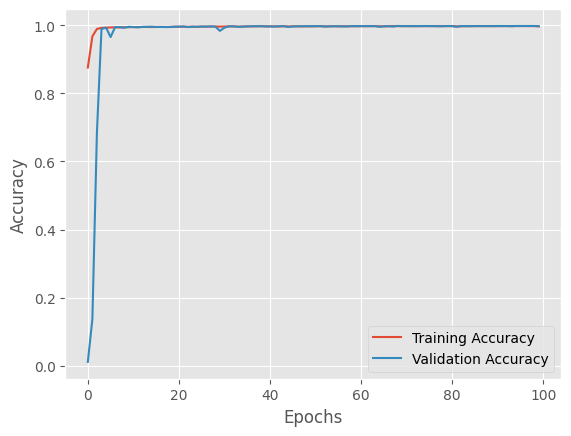

In [28]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

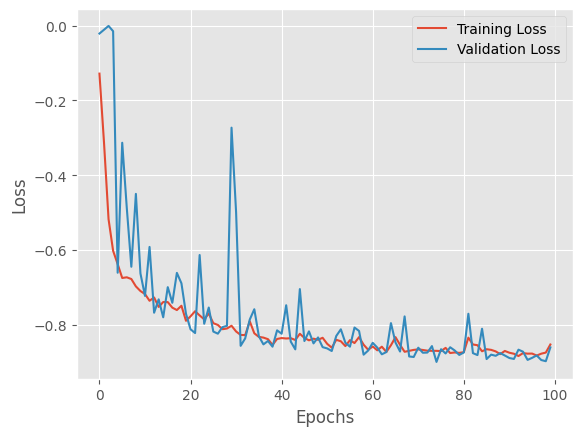

In [29]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

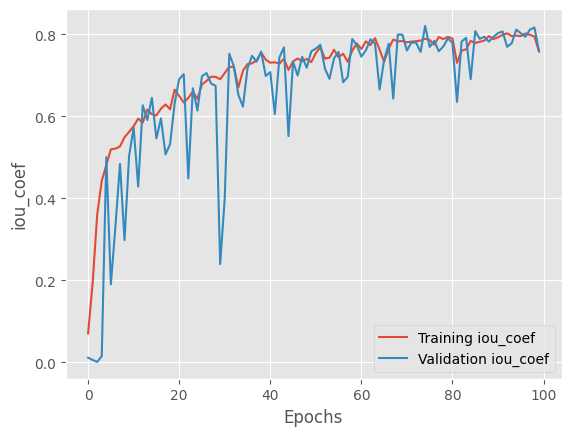

In [31]:
plt.plot(history.history['iou_coef'],label='Training iou_coef')
plt.plot(history.history['val_iou_coef'],label='Validation iou_coef')
plt.xlabel('Epochs')
plt.ylabel('iou_coef')
plt.legend()
plt.show()

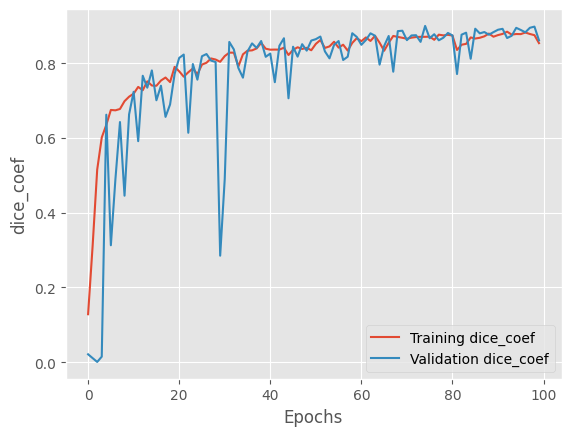

In [32]:
plt.plot(history.history['dice_coef'],label='Training dice_coef')
plt.plot(history.history['val_dice_coef'],label='Validation dice_coef')
plt.xlabel('Epochs')
plt.ylabel('dice_coef')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


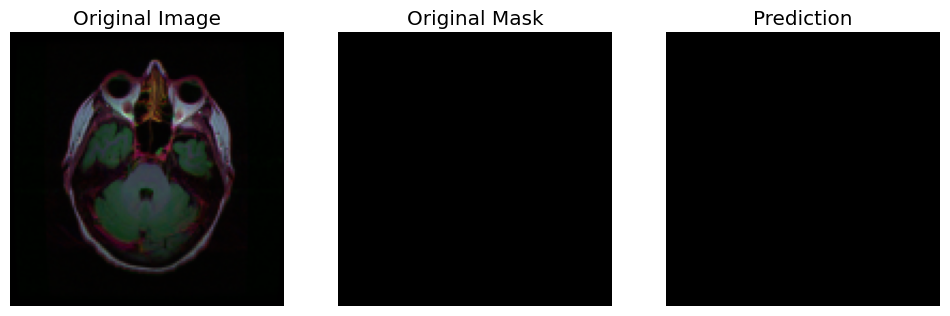

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


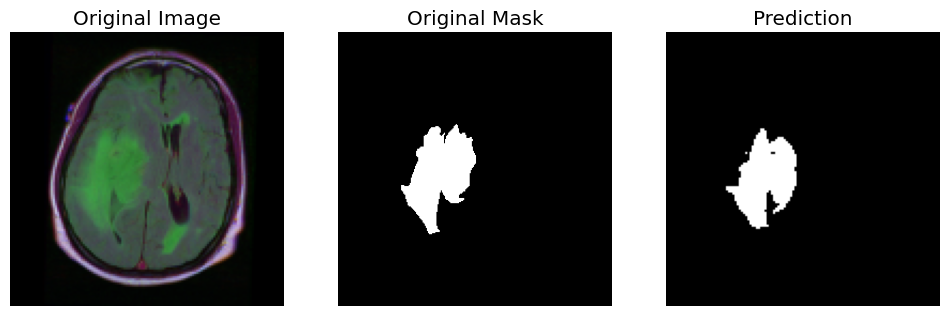

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


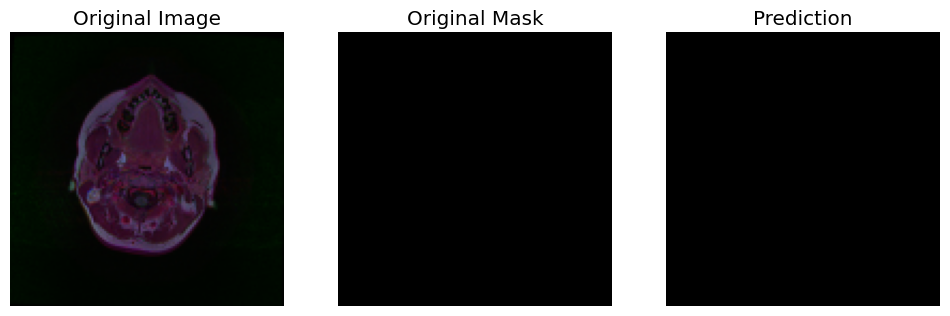

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


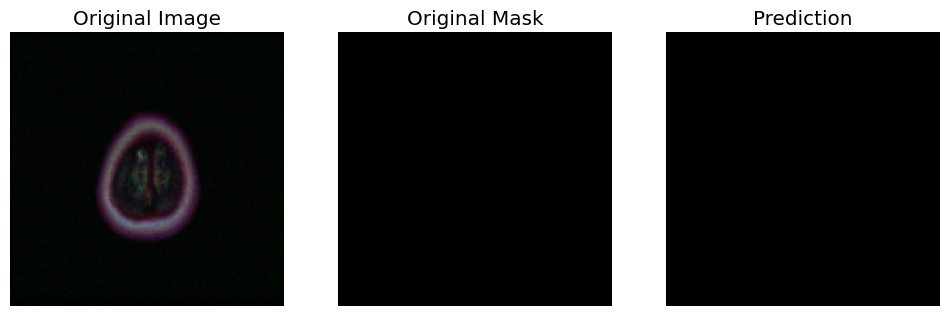

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


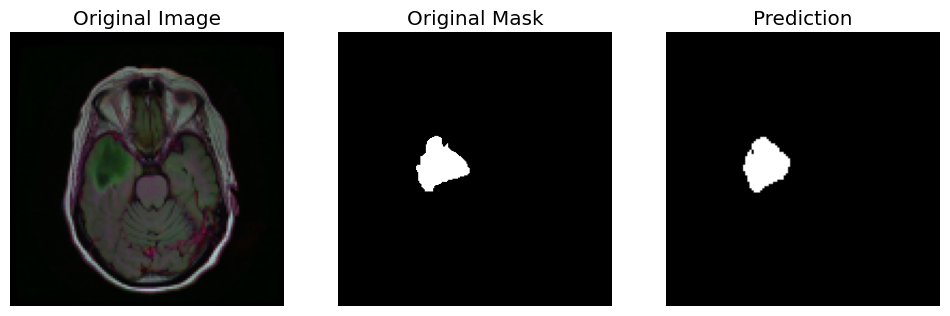

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


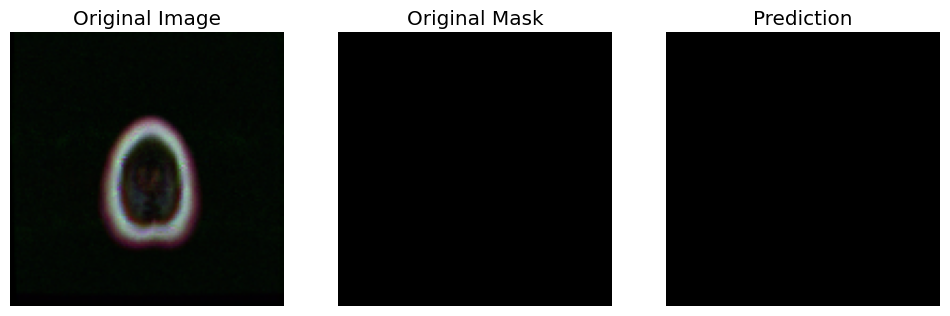

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


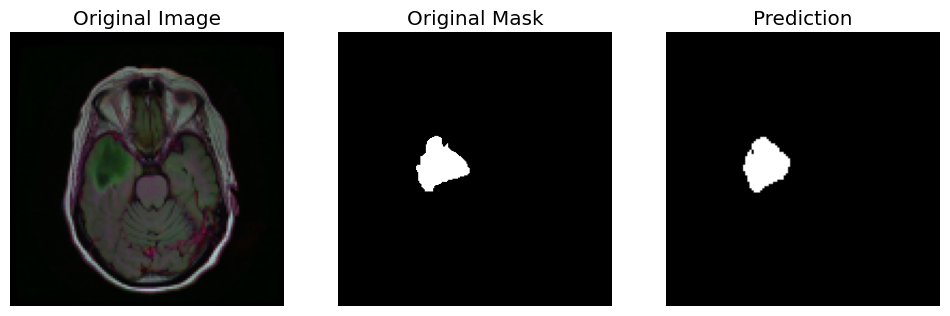

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


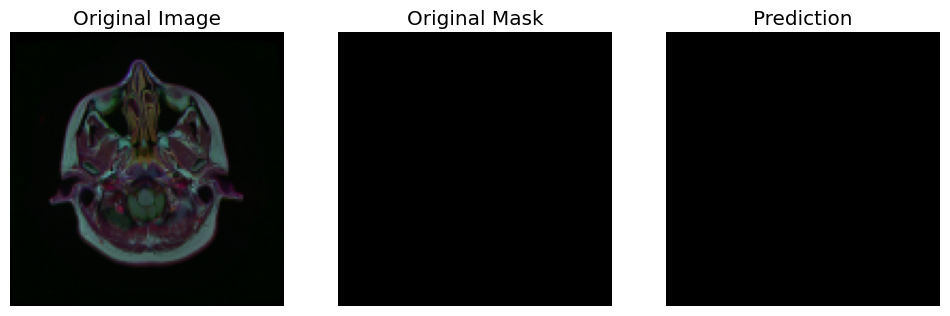

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


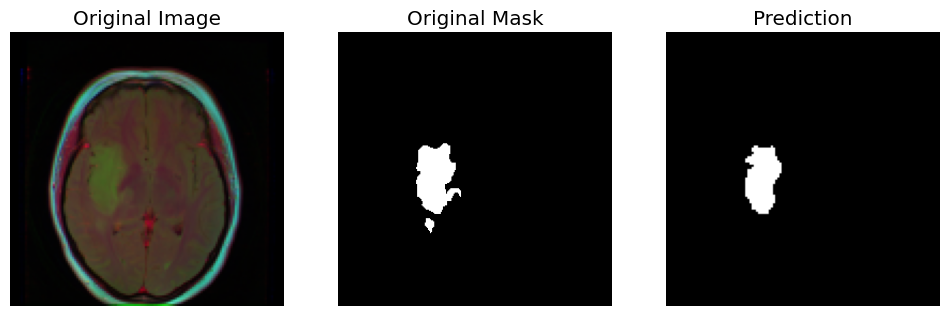

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


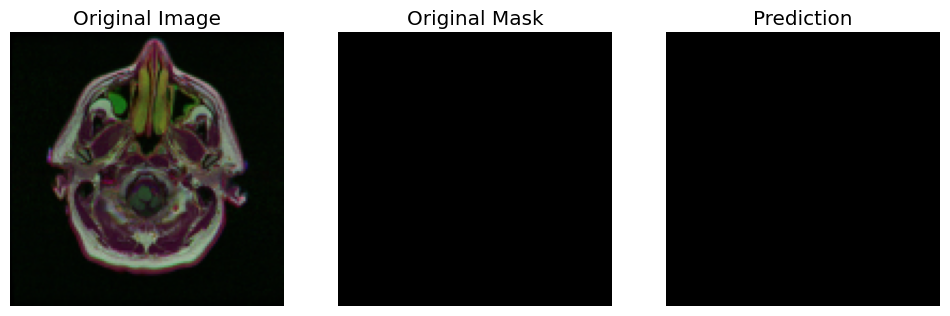

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


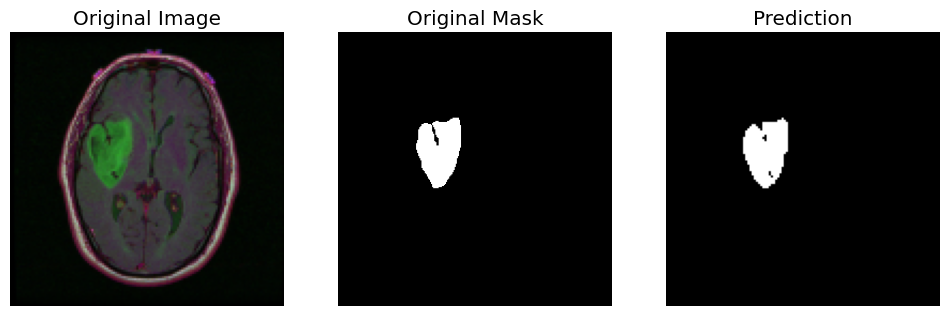

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


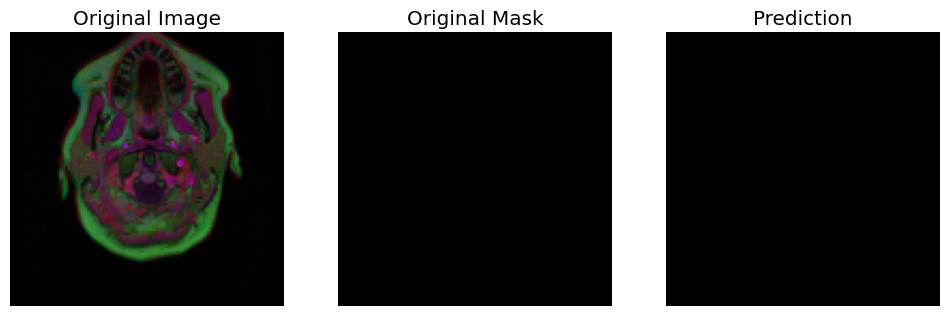

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


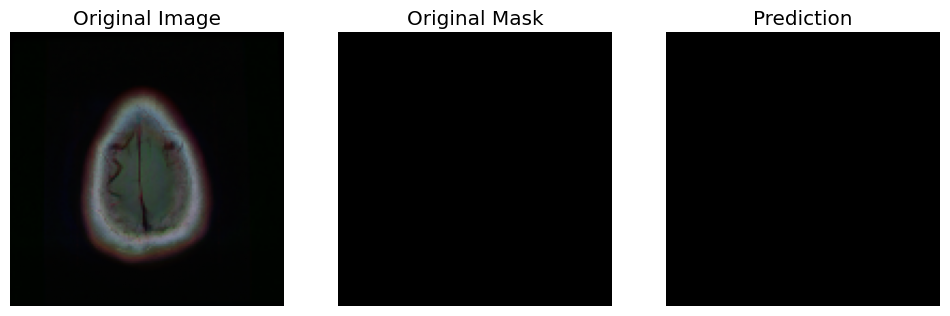

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


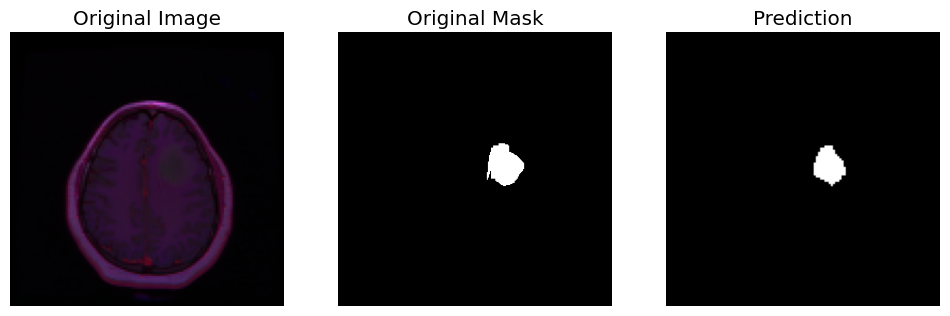

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


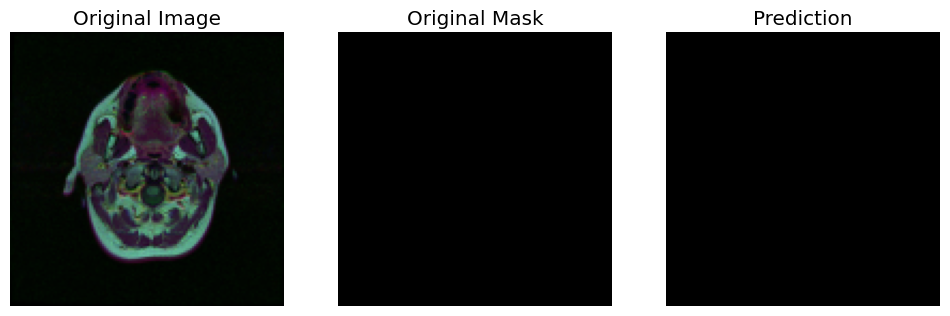

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


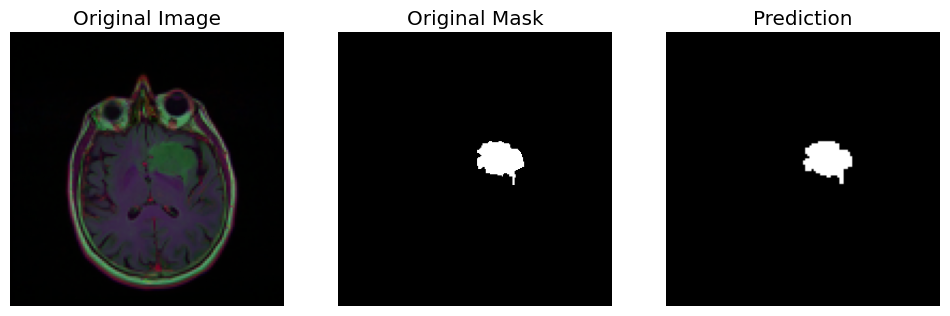

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


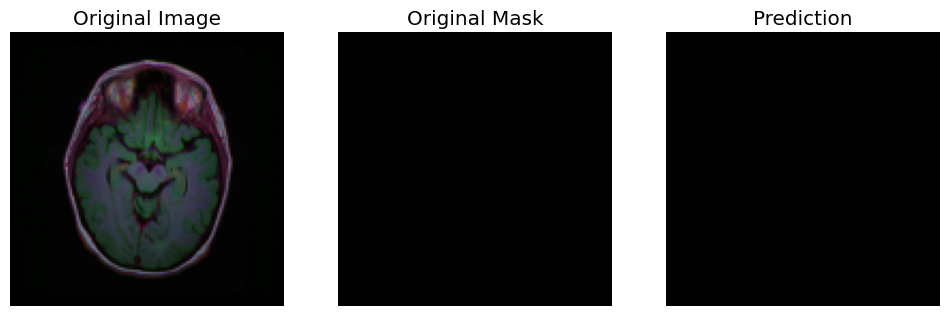

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


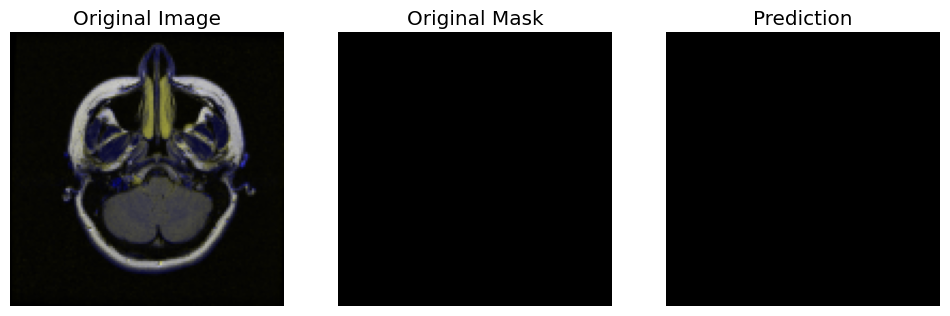

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


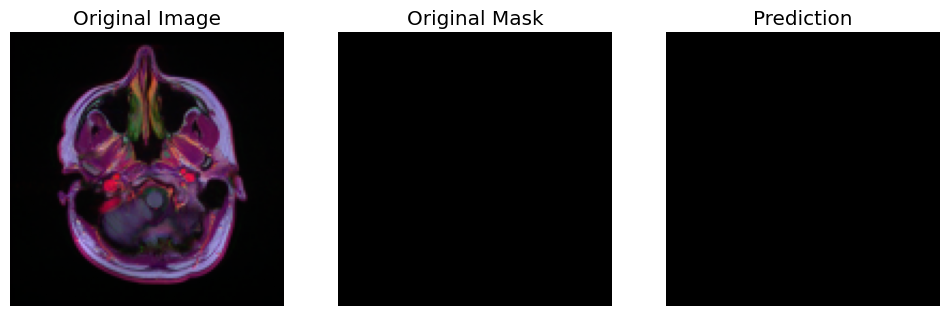

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


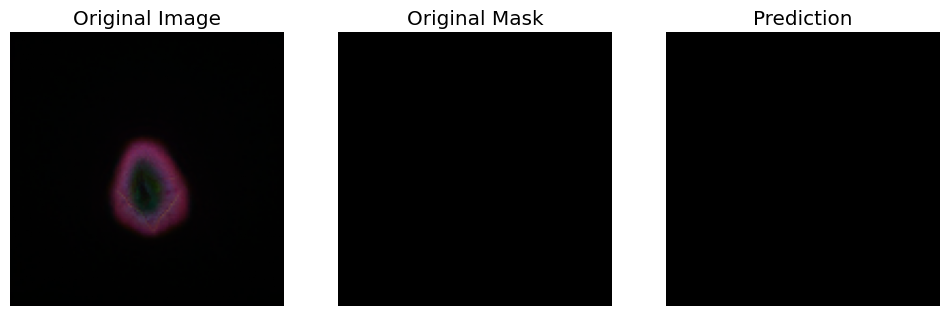

In [27]:
for _ in range(20):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image'].iloc[index])
    img = cv2.resize(img, (128, 128))
    img = img/255
    img = img[np.newaxis, :, :, : ]

    predicted_img = model.predict(img)

    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img),cmap='gray')
    plt.axis('off')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])),cmap='gray')
    plt.axis('off')
    plt.title('Original Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_img) > 0.5,cmap='gray')
    plt.title('Prediction')
    plt.axis('off')
    
    plt.show()
    

# ***Save Model***

In [33]:
model.save('u_net.h5')

# ***Load Model***

In [3]:
loaded_model = keras.models.load_model("/kaggle/input/savemodel/u_net.h5",compile=False)

# ***Deployment***

In [4]:
from PIL import Image
import numpy as np
# Preprocess the image for the model
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((128, 128))  # Resize to the model's input shape
    image = np.array(image) / 255.0  # Normalize
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

In [6]:
def predict(image_path):
    
    processed_image=preprocess_image(image_path)
    
    predicted_mask=loaded_model.predict(processed_image)
    
    plt.imshow(np.squeeze(predicted_mask) > 0.5,cmap='gray')
    plt.axis('off')
    plt.show()
    

I0000 00:00:1730984712.037494      76 service.cc:145] XLA service 0x7a323c003960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730984712.037543      76 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


I0000 00:00:1730984714.703481      76 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


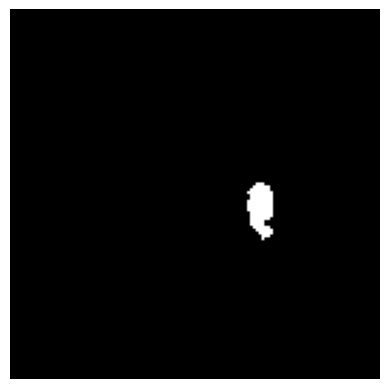

In [7]:
image_path='/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_12.tif'
predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


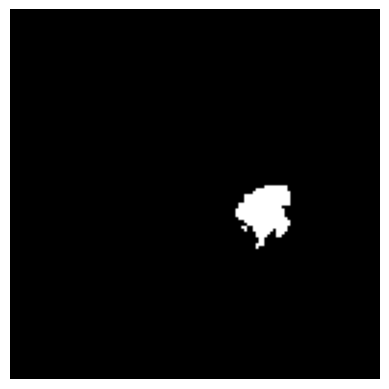

In [8]:
image_path='/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_17.tif'
predict(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


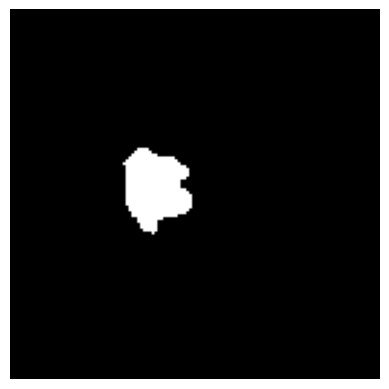

In [16]:
image_path='/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_17.tif'
predict(image_path)